In [1]:
import os, random, numpy as np
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
random.seed(42); np.random.seed(42)

In [2]:
# ==== Install ====
import sys, subprocess, importlib.util
def pip_install(pkgs): subprocess.run([sys.executable, "-m", "pip", "install", "-q"] + pkgs, check=True)
need = []
for p in ["numpy","pandas","scikit-learn","joblib","tqdm","requests","matplotlib",
          "sentence-transformers","transformers","torch","ijson"]:
    if importlib.util.find_spec(p) is None:
        need.append(p)
if need: pip_install(need)

# ==== Imports ====
import os, json, re, time, zipfile
from pathlib import Path
from typing import Dict, List, Tuple, Callable, Optional

import numpy as np
import pandas as pd
import requests, joblib
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

# ==== Paths & knobs ====
USE_GOOGLE_DRIVE = True
BASE = Path("/content/drive/MyDrive/CTC_by_source") if USE_GOOGLE_DRIVE else Path("/content")
RED_PATH = BASE / "CTC_Reddit_10k.json"
STK_PATH = BASE / "CTC_Stackexchange_10k.json"
ARX_PATH = BASE / "CTC_arXiv_10k.json"

WORKDIR = Path("ctc_bench"); WORKDIR.mkdir(parents=True, exist_ok=True)
CACHE = WORKDIR / "cache"; CACHE.mkdir(parents=True, exist_ok=True)

TEST_SIZE = 0.20
VAL_SIZE_WITHIN_TRAIN = 0.125    # 10% of original becomes validation (0.8 * 0.125)
RANDOM_STATE = 42
BATCH_SIZE_TXT = 512

# Authors' repo (dictionary + validation)
CTC_REPO_ZIP = "https://codeload.github.com/epelofske-student/CTC/zip/refs/heads/main"
DICT_REPO_PATH = "English_word_dictionary.txt"
VAL_DIR_CYB = "validation_data_cybersecurity"
VAL_DIR_NON = "validation_data_non_cybersecurity"
DATA = WORKDIR / "data"; DATA.mkdir(exist_ok=True, parents=True)

In [3]:
# Fixed dictionary TF-IDF (paper baseline)
def make_tfidf_dict():
    vocab = sorted({w.strip() for w in DICT_PATH.read_text("utf-8").splitlines() if w.strip()})
    return TfidfVectorizer(vocabulary=vocab, lowercase=True, dtype=np.float32,
                           token_pattern=r"(?u)\b\w+\b", norm="l2", use_idf=True, smooth_idf=True, sublinear_tf=True)

# Free vocab TF-IDF
def make_tfidf_free():
    return TfidfVectorizer(min_df=2, ngram_range=(1,2), lowercase=True, dtype=np.float32)

# Char n-gram TF-IDF
def make_tfidf_char():
    return TfidfVectorizer(analyzer="char", ngram_range=(3,5), lowercase=True, dtype=np.float32)

# CountVectorizer
def make_count():
    return CountVectorizer(min_df=2, ngram_range=(1,2), lowercase=True, dtype=np.int32)

# HashingVectorizer (stateless)
def make_hashing():
    return HashingVectorizer(n_features=2**18, alternate_sign=False, norm="l2", lowercase=True)

# LSA  (TF-IDF -> SVD(256) -> l2-normalize)
def make_lsa():
    tfidf = TfidfVectorizer(min_df=2, ngram_range=(1,2), lowercase=True, dtype=np.float32)
    svd = TruncatedSVD(n_components=256, random_state=RANDOM_STATE)
    norm = Normalizer(copy=False)
    return make_pipeline(tfidf, svd, norm)

# Sentence-Transformers
_SMODELS = {
    "sbert_all-MiniLM-L6-v2": "sentence-transformers/all-MiniLM-L6-v2",
    "e5-small-v2":            "intfloat/e5-small-v2",
    "bge-small-en-v1.5":      "BAAI/bge-small-en-v1.5",
}

def embed_with_sbert(model_name: str, texts: List[str], batch_size: int = 128, device: str = None) -> np.ndarray:
    m = SentenceTransformer(_SMODELS[model_name], device=device or ("cuda" if torch.cuda.is_available() else "cpu"))
    emb = m.encode(texts, batch_size=batch_size, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
    return emb.astype("float32")

# Vanilla Transformers CLS (e.g., distilroberta-base)
def embed_with_transformer_cls(hf_name: str, texts: List[str], batch_size: int = 64) -> np.ndarray:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tok = AutoTokenizer.from_pretrained(hf_name)
    mdl = AutoModel.from_pretrained(hf_name).to(device)
    mdl.eval()
    outs = []
    for i in tqdm(range(0, len(texts), batch_size), desc=f"Encoding {hf_name} CLS"):
        batch = texts[i:i+batch_size]
        enc = tok(batch, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)
        with torch.no_grad():
            out = mdl(**enc).last_hidden_state[:,0,:]  # CLS token
            out = torch.nn.functional.normalize(out, p=2, dim=1)
        outs.append(out.detach().cpu().numpy().astype("float32"))
    return np.vstack(outs)

# Registry of 10 methods
METHODS = {
    # Classic 6
    "tfidf_dict_word":   ("sparse", make_tfidf_dict),
    "tfidf_free_word":   ("sparse", make_tfidf_free),
    "tfidf_char_3_5":    ("sparse", make_tfidf_char),
    "count_word":        ("sparse", make_count),
    "hashing_word":      ("sparse", make_hashing),
    "lsa_tfidf_svd256":  ("dense",  make_lsa),
    # Neural / LLM 4
    "sbert_all-MiniLM-L6-v2": ("dense_embed", lambda: "sbert_all-MiniLM-L6-v2"),
    "e5-small-v2":            ("dense_embed", lambda: "e5-small-v2"),
    "bge-small-en-v1.5":      ("dense_embed", lambda: "bge-small-en-v1.5"),
    "distilroberta-base_CLS": ("dense_hf_cls", lambda: "distilroberta-base"),
}

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

import os, json, zipfile, requests, joblib, re, time, random
import numpy as np
from pathlib import Path
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# ----- CONFIG -----
BASE_DIR = Path("/content/drive/MyDrive/CTC_by_source")
REDDIT = BASE_DIR / "CTC_Reddit_10k.json"
STACK  = BASE_DIR / "CTC_Stackexchange_10k.json"
ARXIV  = BASE_DIR / "CTC_arXiv_10k.json"
COMBO  = BASE_DIR / "CTC_by_source_30k.json"

# Speed knobs
LIMIT_PER_SOURCE = 4000   # set to None for all 10k per source
TEST_SIZE = 0.20
VAL_SIZE_WITHIN_TRAIN = 0.125
RANDOM_STATE = 42

WORKDIR = Path("ctc_fast"); WORKDIR.mkdir(exist_ok=True, parents=True)
MODELDIR = Path("ctc_models_fast"); MODELDIR.mkdir(exist_ok=True, parents=True)
DATA = WORKDIR / "data"; DATA.mkdir(exist_ok=True, parents=True)

# Authors' repo for dictionary + validation (optional at the end)
CTC_REPO_ZIP = "https://codeload.github.com/epelofske-student/CTC/zip/refs/heads/main"
DICT_REPO_PATH = "English_word_dictionary.txt"
VAL_DIR_CYB = "validation_data_cybersecurity"
VAL_DIR_NON = "validation_data_non_cybersecurity"

def stream_download(url: str, out_path: Path, desc: str = None):
    if out_path.exists() and out_path.stat().st_size > 0:
        return out_path
    import requests
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        with open(out_path, "wb") as f, tqdm(total=total, unit="B", unit_scale=True, desc=desc or out_path.name) as pbar:
            for chunk in r.iter_content(1024*1024):
                if chunk:
                    f.write(chunk); pbar.update(len(chunk))
    return out_path

# Cleaning similar to earlier cells
CLEAN_HTML_RE = re.compile(r"<[^>]+>")
URL_RE = re.compile(r"http[s]?://\S+|www\.\S+")
CODE_RE = re.compile(r"`{1,3}.*?`{1,3}", re.DOTALL)
NON_ASCII_RE = re.compile(r"[^\x00-\x7F]+")
WHITESPACE_RE = re.compile(r"\s+")
def clean_text(s: str) -> str:
    if not isinstance(s, str): return ""
    s = URL_RE.sub(" ", s)
    s = CODE_RE.sub(" ", s)
    s = CLEAN_HTML_RE.sub(" ", s)
    s = NON_ASCII_RE.sub(" ", s)
    s = WHITESPACE_RE.sub(" ", s).strip()
    return s

def load_json_arr(path: Path, limit=None, seed=RANDOM_STATE):
    data = json.loads(path.read_text(encoding="utf-8"))
    if limit is not None and len(data) > limit:
        random.Random(seed).shuffle(data)
        data = data[:limit]
    X = [clean_text(d["text"]) for d in data]
    y = [int(d["label"]) for d in data]
    return X, y

# 1) Fetch dictionary
repo_zip = DATA / "CTC-main.zip"
repo_root = DATA / "CTC-main"
if not repo_root.exists():
    stream_download(CTC_REPO_ZIP, repo_zip, "CTC-main.zip")
    with zipfile.ZipFile(repo_zip, "r") as z:
        z.extractall(DATA)
DICT_PATH = repo_root / DICT_REPO_PATH
assert DICT_PATH.exists(), "Dictionary not found in repo"

# 2) Load your data (optionally subsample for speed)
print("Loading data…")
Xr, yr = load_json_arr(REDDIT, limit=LIMIT_PER_SOURCE)
Xs, ys = load_json_arr(STACK,  limit=LIMIT_PER_SOURCE)
Xa, ya = load_json_arr(ARXIV,  limit=LIMIT_PER_SOURCE)

Xall, yall = load_json_arr(COMBO, limit=(None if LIMIT_PER_SOURCE is None else 3*LIMIT_PER_SOURCE))

# 3) Build dictionary TF-IDF and combined splits
vocab = sorted({w.strip() for w in DICT_PATH.read_text("utf-8").splitlines() if w.strip()})
vec = TfidfVectorizer(vocabulary=vocab, lowercase=True, dtype=np.float32,
                      token_pattern=r"(?u)\b\w+\b", norm="l2", use_idf=True, smooth_idf=True, sublinear_tf=True)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    Xall, yall, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=yall
)
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_train_text, y_train, test_size=VAL_SIZE_WITHIN_TRAIN, random_state=RANDOM_STATE, stratify=y_train
)
X_train = vec.fit_transform(X_train_text)
X_val   = vec.transform(X_val_text)
X_test  = vec.transform(X_test_text)
joblib.dump(vec, MODELDIR / "tfidf_vectorizer.joblib")
print("TF-IDF shapes:", X_train.shape, X_val.shape, X_test.shape)

# 4) Classic models per source
def build_classic_models():
    return {
        "DecisionTree": DecisionTreeClassifier(max_depth=100, random_state=RANDOM_STATE),
        "RandomForest": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE),
        "Logistic":     LogisticRegression(max_iter=500, n_jobs=-1, solver="saga", penalty="l2"),
        "LinearSVC":    LinearSVC(),
        "MLP":          MLPClassifier(hidden_layer_sizes=(256,), activation="relu", max_iter=25, random_state=RANDOM_STATE),
    }

def train_source_classics(source_name: str, X_text, y):
    Xtr_txt, Xte_txt, ytr, yte = train_test_split(X_text, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)
    Xtr_txt, Xva_txt, ytr, yva = train_test_split(Xtr_txt, ytr, test_size=0.125, random_state=RANDOM_STATE, stratify=ytr)
    Xtr = vec.transform(Xtr_txt); Xva = vec.transform(Xva_txt); Xte = vec.transform(Xte_txt)

    classics = build_classic_models()
    trained = {}
    for name, model in classics.items():
        print(f"[{source_name}] Training {name} …")
        try:
            if hasattr(model, "class_weight"): model.set_params(class_weight="balanced")
        except Exception:
            pass
        model.fit(Xtr, ytr)
        va_acc = accuracy_score(yva, model.predict(Xva))
        print(f"[{source_name}] {name} val acc: {va_acc:.4f}")
        joblib.dump(model, MODELDIR / f"{source_name}_{name}.joblib")
        trained[f"{source_name}_{name}"] = model
    return trained, (Xte, yte)

def pred_binary(model, X):
    if hasattr(model, "predict"):
        try:
            return model.predict(X).astype(int)
        except Exception:
            pass
    try:
        df = model.decision_function(X)
        return (df > 0).astype(int)
    except Exception:
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X)
            return np.argmax(proba, axis=1).astype(int)
        raise

def majority_vote(preds_bin: list) -> np.ndarray:
    stacked = np.vstack(preds_bin)
    votes = stacked.sum(axis=0)
    return (votes >= (stacked.shape[0]/2.0)).astype(int)

def ctc_predict(vec, models15: dict, X_text: list) -> np.ndarray:
    X = vec.transform(X_text)
    preds = [pred_binary(m, X) for m in models15.values()]
    return majority_vote(preds)

sources = {
    "Reddit": (Xr, yr),
    "Stackexchange": (Xs, ys),
    "arXiv": (Xa, ya),
}

all_models = {}
per_source_tests = {}
for sname, (Xt, yt) in sources.items():
    mcls, (Xte_src, yte_src) = train_source_classics(sname, Xt, yt)
    all_models.update(mcls)
    per_source_tests[sname] = (Xte_src, yte_src)

print("\nClassic models trained:", len(all_models))  # should be 15

# 5) Evaluate ensemble on your combined TEST split
print("\n=== Combined TEST split (FAST) ===")
yhat = ctc_predict(vec, all_models, X_test_text)
acc = accuracy_score(y_test, yhat)
print(f"CTC (15 classic) TEST accuracy: {acc:.4f}")
print(classification_report(y_test, yhat, target_names=["non-cybersecurity","cybersecurity"]))

print("\n✅ FAST run complete. Models saved in:", MODELDIR.resolve())

Mounted at /content/drive
Loading data…
TF-IDF shapes: (8400, 24462) (1200, 24462) (2400, 24462)
[Reddit] Training DecisionTree …
[Reddit] DecisionTree val acc: 0.8925
[Reddit] Training RandomForest …
[Reddit] RandomForest val acc: 0.9350
[Reddit] Training Logistic …
[Reddit] Logistic val acc: 0.9450
[Reddit] Training LinearSVC …
[Reddit] LinearSVC val acc: 0.9400
[Reddit] Training MLP …


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[Reddit] MLP val acc: 0.9525
[Stackexchange] Training DecisionTree …
[Stackexchange] DecisionTree val acc: 0.7850
[Stackexchange] Training RandomForest …
[Stackexchange] RandomForest val acc: 0.8600
[Stackexchange] Training Logistic …
[Stackexchange] Logistic val acc: 0.8800
[Stackexchange] Training LinearSVC …
[Stackexchange] LinearSVC val acc: 0.8775
[Stackexchange] Training MLP …


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[Stackexchange] MLP val acc: 0.8575
[arXiv] Training DecisionTree …
[arXiv] DecisionTree val acc: 0.9500
[arXiv] Training RandomForest …
[arXiv] RandomForest val acc: 0.9700
[arXiv] Training Logistic …
[arXiv] Logistic val acc: 0.9625
[arXiv] Training LinearSVC …
[arXiv] LinearSVC val acc: 0.9825
[arXiv] Training MLP …


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[arXiv] MLP val acc: 0.9675

Classic models trained: 15

=== Combined TEST split (FAST) ===
CTC (15 classic) TEST accuracy: 0.8775
                   precision    recall  f1-score   support

non-cybersecurity       0.83      0.95      0.89      1199
    cybersecurity       0.95      0.80      0.87      1201

         accuracy                           0.88      2400
        macro avg       0.89      0.88      0.88      2400
     weighted avg       0.89      0.88      0.88      2400


✅ FAST run complete. Models saved in: /content/ctc_models_fast


In [1]:
# Per-Source DNN Trainer


BASE_DIR = "/content/drive/MyDrive/CTC_by_source"      # 10k/source JSONs
MODEL_DIR = "ctc_models"                               # Vectorizer & classic models
OUT_DIR   = "ctc_dnn_checkpoints"                      # DNN checkpoints

EPOCHS_PER_CALL = 4
BATCH_SIZE = 512
RANDOM_STATE = 42
TARGETS = {"DNN_t95": 0.95, "DNN_t99": 0.99}

LIMIT_PER_SOURCE = None    # e.g., 6000 to speed up quick runs

# Imports
import os, json, re, zipfile, requests, joblib, glob
import numpy as np
from pathlib import Path
from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Colab niceties
from google.colab import drive
drive.mount("/content/drive", force_remount=False)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
try:
    for g in tf.config.list_physical_devices("GPU"):
        tf.config.experimental.set_memory_growth(g, True)
except Exception:
    pass

# Helpers

CLEAN_HTML_RE = re.compile(r"<[^>]+>")
URL_RE = re.compile(r"http[s]?://\S+|www\.\S+")
CODE_RE = re.compile(r"`{1,3}.*?`{1,3}", re.DOTALL)
NON_ASCII_RE = re.compile(r"[^\x00-\x7F]+")
WHITESPACE_RE = re.compile(r"\s+")

def clean_text(s: str) -> str:
    if not isinstance(s, str): return ""
    s = URL_RE.sub(" ", s)
    s = CODE_RE.sub(" ", s)
    s = CLEAN_HTML_RE.sub(" ", s)
    s = NON_ASCII_RE.sub(" ", s)
    s = WHITESPACE_RE.sub(" ", s).strip()
    return s

def load_ctc_json(p: Path, limit=None, seed=RANDOM_STATE):
    data = json.loads(p.read_text(encoding="utf-8"))
    if limit and len(data) > limit:
        rng = np.random.default_rng(seed); idx = rng.permutation(len(data))[:limit]
        data = [data[i] for i in idx]
    X = [clean_text(d["text"]) for d in data]
    y = [int(d["label"]) for d in data]
    return X, y

def build_dnn(input_dim: int):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.30),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.20),
        layers.Dense(2, activation="softmax"),
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def latest_epoch_ckpt(ckpt_dir: Path):
    files = sorted(ckpt_dir.glob("epoch_*.keras"))
    if not files:
        return None
    return files[-1]

def save_meta(meta_path: Path, meta: dict):
    meta_path.write_text(json.dumps(meta, indent=2), encoding="utf-8")

def load_meta(meta_path: Path):
    if meta_path.exists():
        try:
            return json.loads(meta_path.read_text(encoding="utf-8"))
        except Exception:
            pass
    # default meta
    return {
        "best": { "DNN_t95": {"acc": 0.0, "gap": 1e9, "path": None},
                  "DNN_t99": {"acc": 0.0, "gap": 1e9, "path": None}},
        "epochs_trained": 0
    }

def get_source_paths(source_name: str) -> Path:
    base = Path(BASE_DIR)
    mapping = {
        "Reddit":       "CTC_Reddit_10k.json",
        "Stackexchange":"CTC_Stackexchange_10k.json",
        "arXiv":        "CTC_arXiv_10k.json",
    }
    fn = mapping.get(source_name)
    if not fn:
        raise ValueError("source_name must be one of: 'Reddit', 'Stackexchange', 'arXiv'")
    p = base / fn
    if not p.exists():
        raise FileNotFoundError(f"Not found: {p}")
    return p

def load_vectorizer_or_fail():
    vec_path = Path(MODEL_DIR) / "tfidf_vectorizer.joblib"
    if not vec_path.exists():
        raise FileNotFoundError(f"Can't find vectorizer at {vec_path}. "
                                f"Run the FAST runner or the full pipeline once to create it.")
    return joblib.load(vec_path)

# Main callable

def train_dnn_source(source_name: str,
                     epochs_this_call: int = EPOCHS_PER_CALL,
                     batch_size: int = BATCH_SIZE,
                     limit_per_source = LIMIT_PER_SOURCE):
    """
    Train/Resume DNN for a single source.
    Splits that source 80/20 then 12.5% of train as val (≈10% of original).
    Saves:
      - per-epoch checkpoints: {OUT_DIR}/{source}/epoch_{N}.keras
      - best-by-target:        {OUT_DIR}/{source}/{source}_DNN_t95.keras and _t99.keras
      - meta.json with best accuracies & epochs_trained
    """
    print(f"\n=== DNN training for source: {source_name} ===")
    src_path = get_source_paths(source_name)
    vec = load_vectorizer_or_fail()

    # Load data for this source
    X, y = load_ctc_json(src_path, limit=limit_per_source)
    Xtr_txt, Xte_txt, ytr, yte = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)
    Xtr_txt, Xva_txt, ytr, yva = train_test_split(Xtr_txt, ytr, test_size=0.125, random_state=RANDOM_STATE, stratify=ytr)

    # Vectorize and densify (DNN needs dense)
    Xtr = vec.transform(Xtr_txt).toarray()
    Xva = vec.transform(Xva_txt).toarray()

    # Prepare dirs
    out_root = Path(OUT_DIR); out_root.mkdir(parents=True, exist_ok=True)
    ckpt_dir = out_root / source_name; ckpt_dir.mkdir(parents=True, exist_ok=True)
    meta_path = ckpt_dir / "meta.json"
    meta = load_meta(meta_path)

    # Create or resume model
    latest = latest_epoch_ckpt(ckpt_dir)
    if latest:
        print(f"Resuming from latest checkpoint: {latest.name}")
        dnn = keras.models.load_model(latest)
        start_epoch = int(latest.stem.split("_")[-1]) + 1
    else:
        print("No prior checkpoint — starting fresh.")
        dnn = build_dnn(Xtr.shape[1])
        start_epoch = 1

    # Train a few epochs this call
    for ep in range(start_epoch, start_epoch + epochs_this_call):
        dnn.fit(Xtr, np.array(ytr), epochs=1, batch_size=batch_size, verbose=1)
        va_loss, va_acc = dnn.evaluate(Xva, np.array(yva), verbose=0)
        print(f"[{source_name}] epoch {ep} — val acc: {va_acc:.4f}")

        # Save epoch checkpoint
        ep_path = ckpt_dir / f"epoch_{ep:03d}.keras"
        dnn.save(ep_path)

        # Update best-by-target checkpoints
        for tag, targ in TARGETS.items():
            gap = abs(float(va_acc) - targ)
            if gap < meta["best"][tag]["gap"]:
                best_path = ckpt_dir / f"{source_name}_{tag}.keras"
                dnn.save(best_path)
                meta["best"][tag] = {"acc": float(va_acc), "gap": float(gap), "path": str(best_path)}
                print(f"  ↳ Updated {tag} ({targ:.2f}) → acc={va_acc:.4f}, saved: {best_path.name}")

        meta["epochs_trained"] = ep
        save_meta(meta_path, meta)

    print("\n✅ Done for", source_name)
    print("Best snapshots so far:")
    for tag, info in meta["best"].items():
        print(f"  {tag}: acc≈{info['acc']:.4f}, path={info['path']}")
    print(f"All checkpoints in: {ckpt_dir.resolve()}")

KeyboardInterrupt: 

In [7]:
import os, json, re, zipfile, time, importlib.util, subprocess, warnings
from pathlib import Path
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
from tqdm import tqdm

# Ensure deps (quiet)
def _pip(pkgs): subprocess.run(["python","-m","pip","install","-q",*pkgs], check=True)
_need = []
for p in ["scikit-learn","pandas","numpy","matplotlib","tqdm","requests","joblib","sentence-transformers","transformers","torch","seaborn"]:
    if importlib.util.find_spec(p) is None: _need.append(p)
if _need: _pip(_need)

import requests, joblib, matplotlib.pyplot as plt, seaborn as sns, torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

warnings.filterwarnings("ignore")

# ---------- Config defaults (safe to override when calling the function)
_VCFG = {
    "base_dir": "/content/drive/MyDrive/CTC_by_source",  # where your 3 per-source JSONs live
    "reddit": "CTC_Reddit_10k.json",
    "stack":  "CTC_Stackexchange_10k.json",
    "arxiv":  "CTC_arXiv_10k.json",
    "workdir": "ctc_bench",
    "results_csv": "vectorizer_bench_results.csv",
    "test_size": 0.20,
    "val_size_within_train": 0.125,   # -> ~10% val
    "random_state": 42,
    "sbert_batch": 128,
    "hf_cls_batch": 64,
    "hf_max_len": 256,
    # authors' repo for fixed dictionary TF-IDF (paper-faithful baseline)
    "ctc_repo_zip": "https://codeload.github.com/epelofske-student/CTC/zip/refs/heads/main",
    "dict_rel_path": "English_word_dictionary.txt",
}

# ---------- Small helpers
_CLEAN_HTML_RE = re.compile(r"<[^>]+>")
_URL_RE  = re.compile(r"http[s]?://\S+|www\.\S+")
_CODE_RE = re.compile(r"`{1,3}.*?`{1,3}", re.DOTALL)
_NON_ASCII_RE = re.compile(r"[^\x00-\x7F]+")
_WS_RE = re.compile(r"\s+")
def _clean(s: str) -> str:
    if not isinstance(s, str): return ""
    s = _URL_RE.sub(" ", s); s = _CODE_RE.sub(" ", s); s = _CLEAN_HTML_RE.sub(" ", s)
    s = _NON_ASCII_RE.sub(" ", s); s = _WS_RE.sub(" ", s).strip()
    return s

def _load_ctc_json(p: Path, limit=None, seed=42):
    data = json.loads(p.read_text(encoding="utf-8"))
    if limit and len(data) > limit:
        rng = np.random.default_rng(seed); idx = rng.permutation(len(data))[:limit]
        data = [data[i] for i in idx]
    X = [_clean(d["text"]) for d in data]; y = [int(d["label"]) for d in data]
    return X, y

def _stream_download(url: str, out_path: Path, desc: str = None):
    if out_path.exists() and out_path.stat().st_size > 0: return out_path
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        with open(out_path, "wb") as f, tqdm(total=total, unit="B", unit_scale=True, desc=desc or out_path.name) as pbar:
            for chunk in r.iter_content(1024*1024):
                if chunk: f.write(chunk); pbar.update(len(chunk))
    return out_path

def _fetch_dictionary(workdir: Path) -> Path:
    data = workdir / "data"; data.mkdir(parents=True, exist_ok=True)
    repo_zip = data / "CTC-main.zip"; repo_root = data / "CTC-main"
    if not repo_root.exists():
        _stream_download(_VCFG["ctc_repo_zip"], repo_zip, "CTC-main.zip")
        with zipfile.ZipFile(repo_zip, "r") as z: z.extractall(data)
    dict_path = repo_root / _VCFG["dict_rel_path"]
    assert dict_path.exists(), "Dictionary not found in authors' repo"
    return dict_path

# ---------- Vectorizers/Embedders
def _tfidf_dict(dict_path: Path):
    vocab = sorted({w.strip() for w in dict_path.read_text("utf-8").splitlines() if w.strip()})
    return TfidfVectorizer(vocabulary=vocab, lowercase=True, dtype=np.float32,
                           token_pattern=r"(?u)\b\w+\b", norm="l2", use_idf=True, smooth_idf=True, sublinear_tf=True)
def _tfidf_free(): return TfidfVectorizer(min_df=2, ngram_range=(1,2), lowercase=True, dtype=np.float32)
def _tfidf_char(): return TfidfVectorizer(analyzer="char", ngram_range=(3,5), lowercase=True, dtype=np.float32)
def _count(): return CountVectorizer(min_df=2, ngram_range=(1,2), lowercase=True, dtype=np.int32)
def _hashing(): return HashingVectorizer(n_features=2**18, alternate_sign=False, norm="l2", lowercase=True)
def _lsa():
    tfidf = TfidfVectorizer(min_df=2, ngram_range=(1,2), lowercase=True, dtype=np.float32)
    svd = TruncatedSVD(n_components=256, random_state=_VCFG["random_state"]); norm = Normalizer(copy=False)
    return make_pipeline(tfidf, svd, norm)

_ST = {
    "sbert_all-MiniLM-L6-v2": "sentence-transformers/all-MiniLM-L6-v2",
    "e5-small-v2":            "intfloat/e5-small-v2",
    "bge-small-en-v1.5":      "BAAI/bge-small-en-v1.5",
}
def _embed_sbert(key, texts, batch):
    dev = "cuda" if torch.cuda.is_available() else "cpu"
    m = SentenceTransformer(_ST[key], device=dev)
    emb = m.encode(texts, batch_size=batch, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
    return emb.astype("float32")

def _embed_cls(hf_name, texts, batch, max_len):
    dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tok = AutoTokenizer.from_pretrained(hf_name)
    mdl = AutoModel.from_pretrained(hf_name).to(dev); mdl.eval()
    outs = []
    for i in tqdm(range(0, len(texts), batch), desc=f"Encoding {hf_name} CLS"):
        batch_txt = texts[i:i+batch]
        enc = tok(batch_txt, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(dev)
        with torch.no_grad():
            out = mdl(**enc).last_hidden_state[:,0,:]
            out = torch.nn.functional.normalize(out, p=2, dim=1)
        outs.append(out.detach().cpu().numpy().astype("float32"))
    return np.vstack(outs)

# Registry builder (needs dict_path at runtime)
def _build_methods(dict_path: Path, methods_subset=None):
    methods = {
        # Classic 6
        "tfidf_dict_word":   ("sparse", lambda: _tfidf_dict(dict_path)),
        "tfidf_free_word":   ("sparse", _tfidf_free),
        "tfidf_char_3_5":    ("sparse", _tfidf_char),
        "count_word":        ("sparse", _count),
        "hashing_word":      ("sparse", _hashing),
        "lsa_tfidf_svd256":  ("dense",  _lsa),
        # Neural 4
        "sbert_all-MiniLM-L6-v2": ("dense_embed", lambda: "sbert_all-MiniLM-L6-v2"),
        "e5-small-v2":            ("dense_embed", lambda: "e5-small-v2"),
        "bge-small-en-v1.5":      ("dense_embed", lambda: "bge-small-en-v1.5"),
        "distilroberta-base_CLS": ("dense_hf_cls", lambda: "distilroberta-base"),
    }
    if methods_subset:
        return {k:v for k,v in methods.items() if k in methods_subset}
    return methods

# ---------- Core train/eval per method
def _split(X, y):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=_VCFG["test_size"], random_state=_VCFG["random_state"], stratify=y)
    X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=_VCFG["val_size_within_train"], random_state=_VCFG["random_state"], stratify=y_tr)
    return X_tr, y_tr, X_va, y_va, X_te, y_te

def _train_eval_method(method_name, X_tr_txt, y_tr, X_va_txt, y_va, X_te_txt, y_te, methods, cache_dir: Path):
    mtype, factory = methods[method_name]
    timings = {}
    if mtype in ("sparse","dense"):
        vec = factory()
        t0=time.time(); X_tr=vec.fit_transform(X_tr_txt); timings["fit_vectorizer_s"]=time.time()-t0
        t1=time.time(); X_va=vec.transform(X_va_txt); X_te=vec.transform(X_te_txt); timings["transform_s"]=time.time()-t1
        clf = LinearSVC() if mtype=="sparse" else LogisticRegression(max_iter=1000, n_jobs=-1, solver="lbfgs")
        t2=time.time(); clf.fit(X_tr,y_tr); timings["fit_clf_s"]=time.time()-t2
        t3=time.time(); yhat=clf.predict(X_te); timings["infer_s"]=time.time()-t3
        acc=accuracy_score(y_te,yhat); report=classification_report(y_te,yhat,output_dict=True)
        return acc, report, timings
    elif mtype=="dense_embed":
        key = factory()
        c_tr=cache_dir/f"{method_name}_train.npy"; c_va=cache_dir/f"{method_name}_val.npy"; c_te=cache_dir/f"{method_name}_test.npy"
        if c_tr.exists() and c_va.exists() and c_te.exists():
            X_tr=np.load(c_tr); X_va=np.load(c_va); X_te=np.load(c_te)
        else:
            X_tr=_embed_sbert(key, X_tr_txt, _VCFG["sbert_batch"])
            X_va=_embed_sbert(key, X_va_txt, _VCFG["sbert_batch"])
            X_te=_embed_sbert(key, X_te_txt, _VCFG["sbert_batch"])
            np.save(c_tr,X_tr); np.save(c_va,X_va); np.save(c_te,X_te)
        clf=LogisticRegression(max_iter=1000, n_jobs=-1, solver="lbfgs")
        t2=time.time(); clf.fit(X_tr,y_tr); timings["fit_clf_s"]=time.time()-t2
        t3=time.time(); yhat=clf.predict(X_te); timings["infer_s"]=time.time()-t3
        acc=accuracy_score(y_te,yhat); report=classification_report(y_te,yhat,output_dict=True)
        return acc, report, timings
    elif mtype=="dense_hf_cls":
        hf="distilroberta-base"
        c_tr=cache_dir/f"{method_name}_train.npy"; c_va=cache_dir/f"{method_name}_val.npy"; c_te=cache_dir/f"{method_name}_test.npy"
        if c_tr.exists() and c_va.exists() and c_te.exists():
            X_tr=np.load(c_tr); X_va=np.load(c_va); X_te=np.load(c_te)
        else:
            X_tr=_embed_cls(hf, X_tr_txt, _VCFG["hf_cls_batch"], _VCFG["hf_max_len"])
            X_va=_embed_cls(hf, X_va_txt, _VCFG["hf_cls_batch"], _VCFG["hf_max_len"])
            X_te=_embed_cls(hf, X_te_txt, _VCFG["hf_cls_batch"], _VCFG["hf_max_len"])
            np.save(c_tr,X_tr); np.save(c_va,X_va); np.save(c_te,X_te)
        clf=LogisticRegression(max_iter=1000, n_jobs=-1, solver="lbfgs")
        t2=time.time(); clf.fit(X_tr,y_tr); timings["fit_clf_s"]=time.time()-t2
        t3=time.time(); yhat=clf.predict(X_te); timings["infer_s"]=time.time()-t3
        acc=accuracy_score(y_te,yhat); report=classification_report(y_te,yhat,output_dict=True)
        return acc, report, timings
    else:
        raise ValueError(mtype)

# ---------- Public runner
def run_vectorizer_benchmark_10(base_dir: str = None,
                                reddit: str = None,
                                stack: str = None,
                                arxiv: str = None,
                                limit_per_source: int | None = None,
                                methods: List[str] | None = None,
                                results_csv: str | None = None):
    """
    Drop-in benchmark: compare 10 vectorizers on Reddit/Stackexchange/arXiv subsets.
    """
    # Resolve config
    cfg = _VCFG.copy()
    if base_dir: cfg["base_dir"] = base_dir
    if reddit:   cfg["reddit"]   = reddit
    if stack:    cfg["stack"]    = stack
    if arxiv:    cfg["arxiv"]    = arxiv
    if results_csv: cfg["results_csv"] = results_csv

    base = Path(cfg["base_dir"])
    rp, sp, ap = base/cfg["reddit"], base/cfg["stack"], base/cfg["arxiv"]
    for p in [rp, sp, ap]:
        assert p.exists(), f"Missing file: {p}"

    workdir = Path(cfg["workdir"]); workdir.mkdir(parents=True, exist_ok=True)
    cache = workdir/"cache"; cache.mkdir(parents=True, exist_ok=True)

    # Fetch dictionary (for tfidf_dict_word)
    dict_path = _fetch_dictionary(workdir)

    # Load data (optionally limit per source for speed)
    Xr, yr = _load_ctc_json(rp, limit=limit_per_source, seed=cfg["random_state"])
    Xs, ys = _load_ctc_json(sp, limit=limit_per_source, seed=cfg["random_state"])
    Xa, ya = _load_ctc_json(ap, limit=limit_per_source, seed=cfg["random_state"])

    # Build methods registry
    METHODS = _build_methods(dict_path, methods_subset=methods)

    # Run per source
    def bench(name, X, y):
        Xtr, ytr, Xva, yva, Xte, yte = _split(X, y)
        rows=[]
        for m in METHODS.keys():
            print(f"[{name}] {m}")
            acc, report, timing = _train_eval_method(m, Xtr, ytr, Xva, yva, Xte, yte, METHODS, cache)
            rows.append({"source":name, "method":m, "accuracy":acc, **timing})
        return pd.DataFrame(rows)

    df_r = bench("Reddit", Xr, yr)
    df_s = bench("Stackexchange", Xs, ys)
    df_a = bench("arXiv", Xa, ya)

    df_all = pd.concat([df_r, df_s, df_a], ignore_index=True)
    out_csv = workdir / cfg["results_csv"]
    df_all.to_csv(out_csv, index=False)
    print("\n✅ Saved:", out_csv)

    # Plots
    sns.set_theme(style="whitegrid")
    for src in ["Reddit","Stackexchange","arXiv"]:
        d = df_all[df_all["source"]==src].sort_values("accuracy", ascending=False)
        plt.figure(figsize=(10,5)); plt.bar(d["method"], d["accuracy"])
        plt.xticks(rotation=60, ha="right"); plt.ylim(0,1); plt.title(f"{src} — Accuracy by method"); plt.ylabel("Accuracy"); plt.show()

    for key, title in [
        ("fit_vectorizer_s","Vectorizer/Embedder Fit Time (s)"),
        ("transform_s",     "Transform/Embed Time (s)"),
        ("fit_clf_s",       "Classifier Fit Time (s)"),
        ("infer_s",         "Inference Time (s)"),
    ]:
        for src in ["Reddit","Stackexchange","arXiv"]:
            d = df_all[df_all["source"]==src]
            if key not in d.columns: continue
            d = d.sort_values(key, ascending=True)
            plt.figure(figsize=(10,5)); plt.bar(d["method"], d[key])
            plt.xticks(rotation=60, ha="right"); plt.title(f"{src} — {title}"); plt.ylabel("Seconds"); plt.show()

    return df_all

[Reddit] tfidf_dict_word
[Reddit] tfidf_free_word
[Reddit] tfidf_char_3_5
[Reddit] count_word
[Reddit] hashing_word
[Reddit] lsa_tfidf_svd256
[Reddit] sbert_all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

[Reddit] e5-small-v2


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

[Reddit] bge-small-en-v1.5


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

[Reddit] distilroberta-base_CLS


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Encoding distilroberta-base CLS: 100%|██████████| 10/10 [04:26<00:00, 26.62s/it]


[Stackexchange] tfidf_dict_word
[Stackexchange] tfidf_free_word
[Stackexchange] tfidf_char_3_5
[Stackexchange] count_word
[Stackexchange] hashing_word
[Stackexchange] lsa_tfidf_svd256
[Stackexchange] sbert_all-MiniLM-L6-v2
[Stackexchange] e5-small-v2
[Stackexchange] bge-small-en-v1.5
[Stackexchange] distilroberta-base_CLS
[arXiv] tfidf_dict_word
[arXiv] tfidf_free_word
[arXiv] tfidf_char_3_5
[arXiv] count_word
[arXiv] hashing_word
[arXiv] lsa_tfidf_svd256
[arXiv] sbert_all-MiniLM-L6-v2
[arXiv] e5-small-v2
[arXiv] bge-small-en-v1.5
[arXiv] distilroberta-base_CLS

✅ Saved: ctc_bench/vectorizer_bench_results.csv


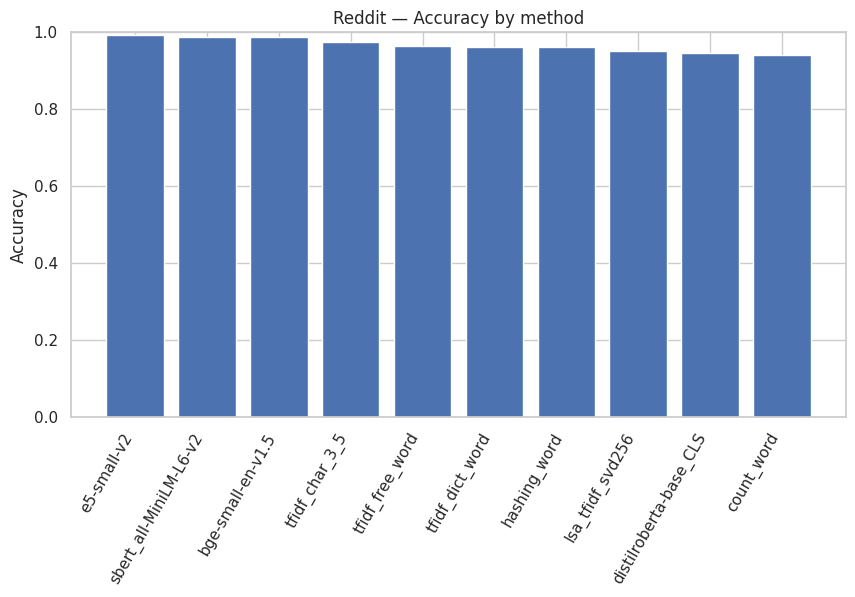

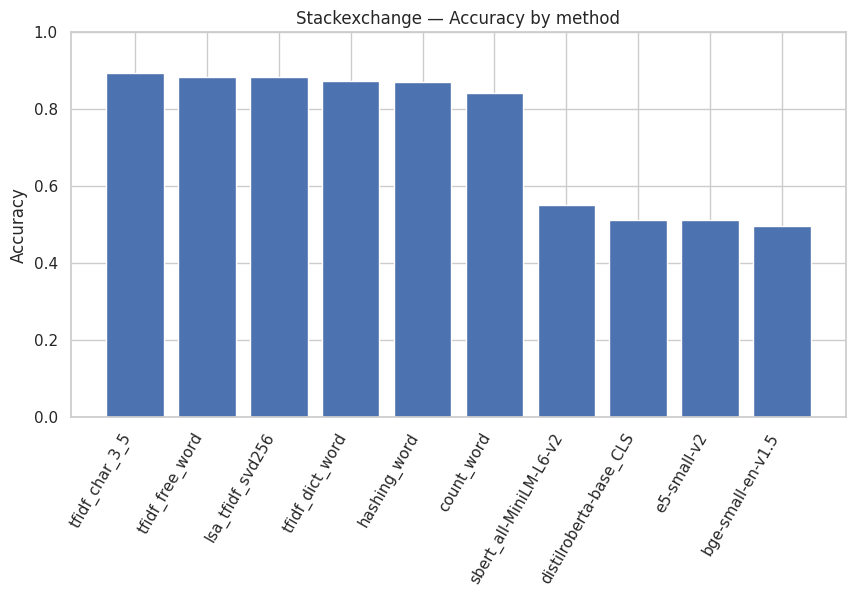

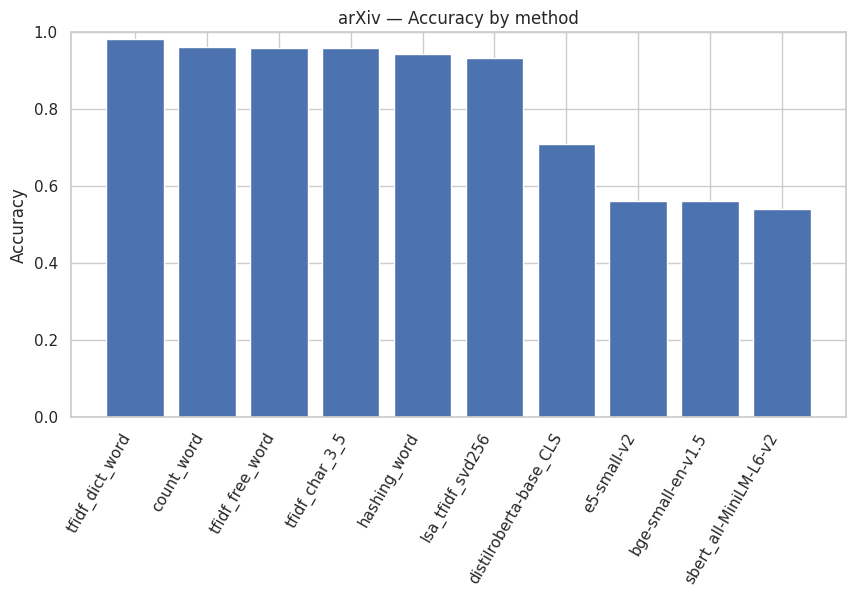

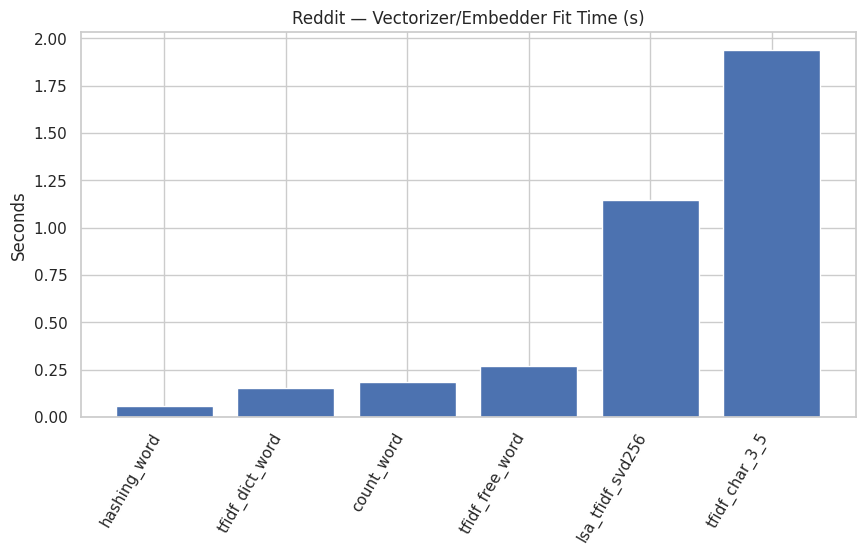

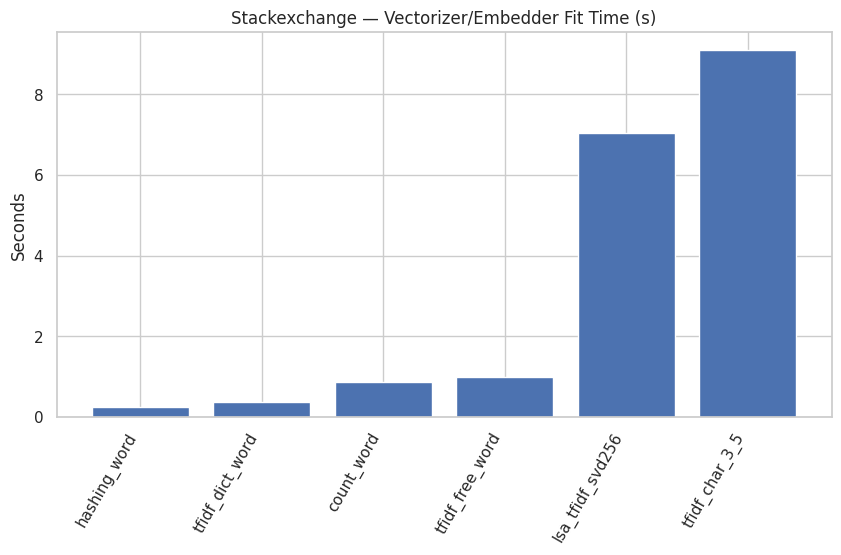

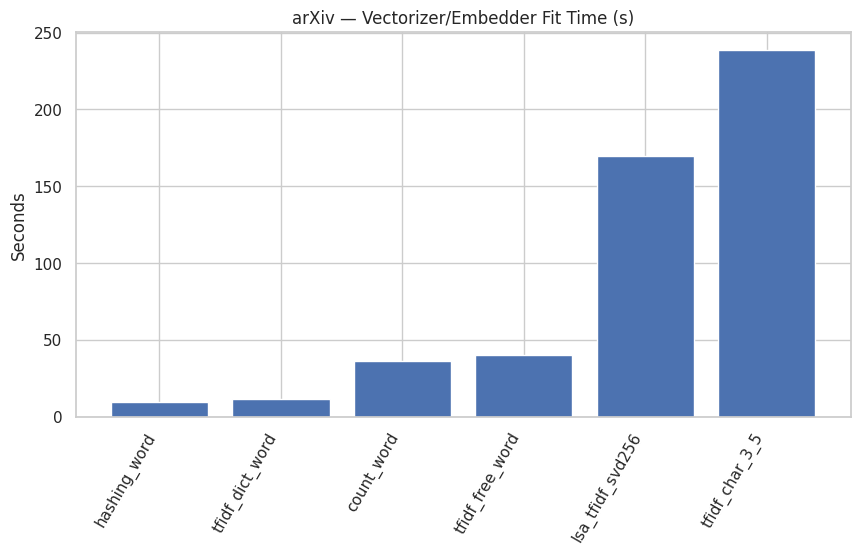

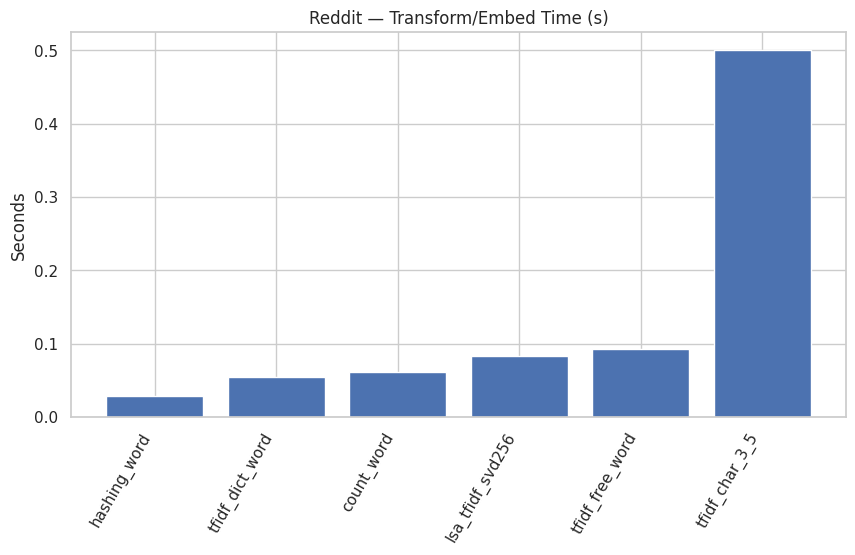

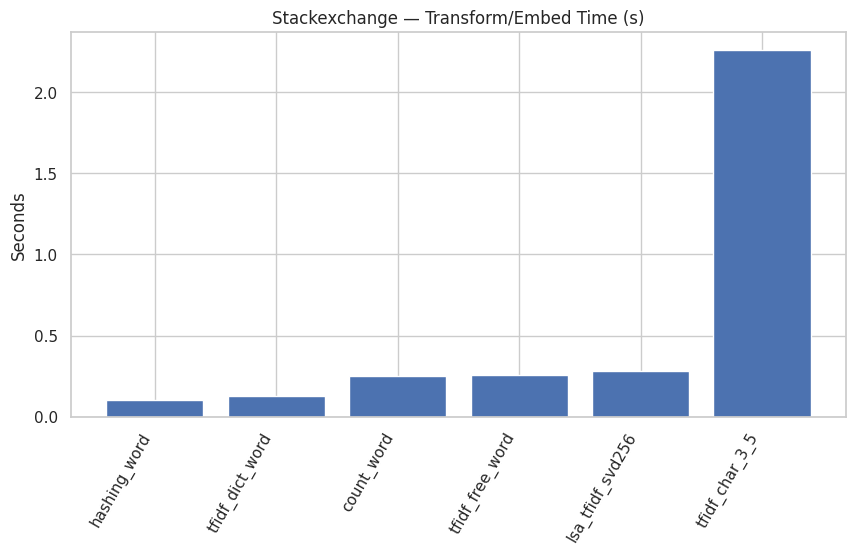

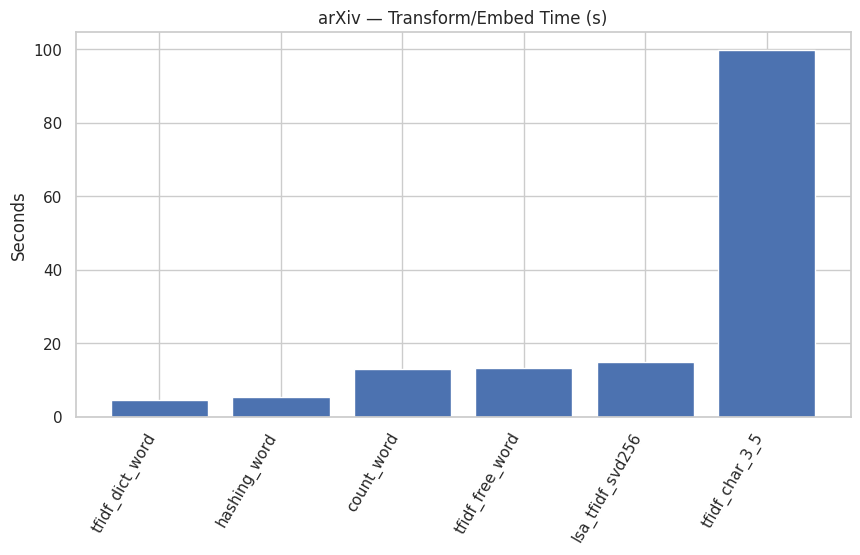

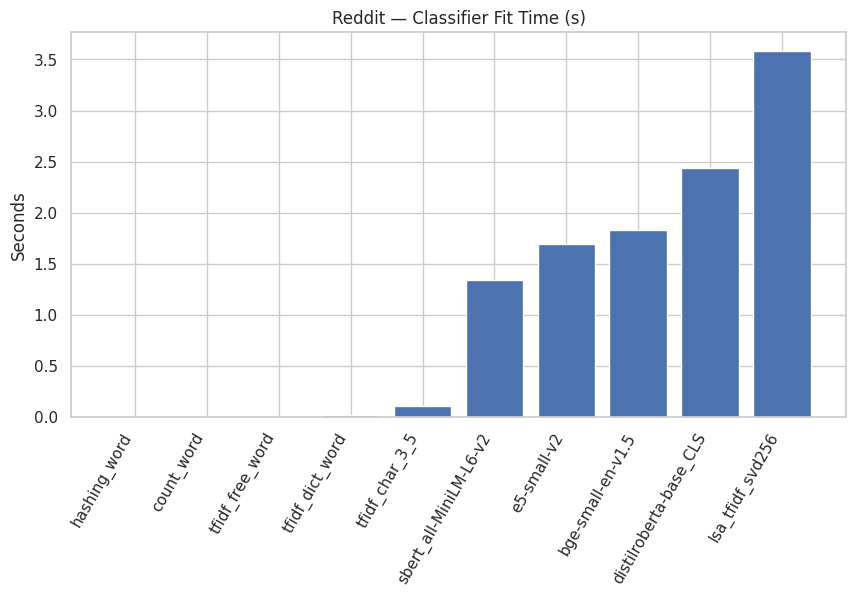

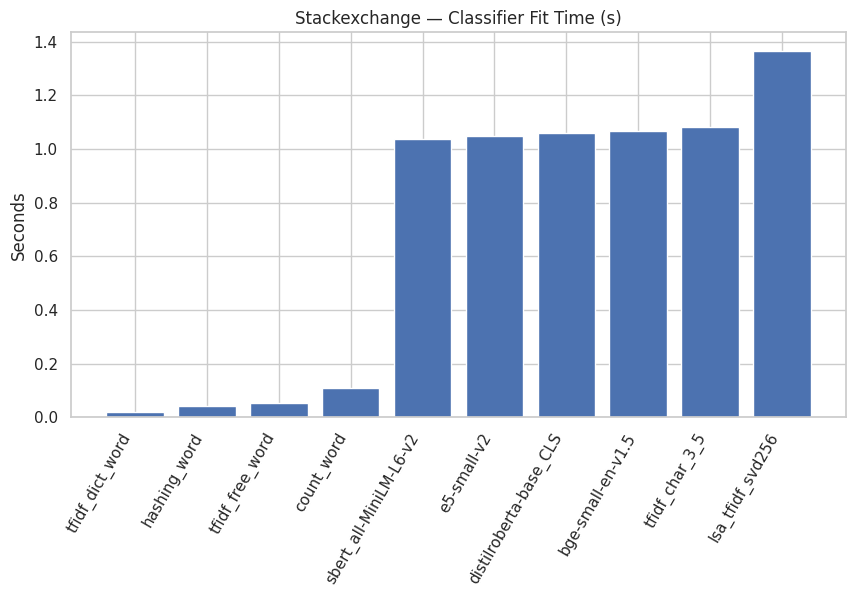

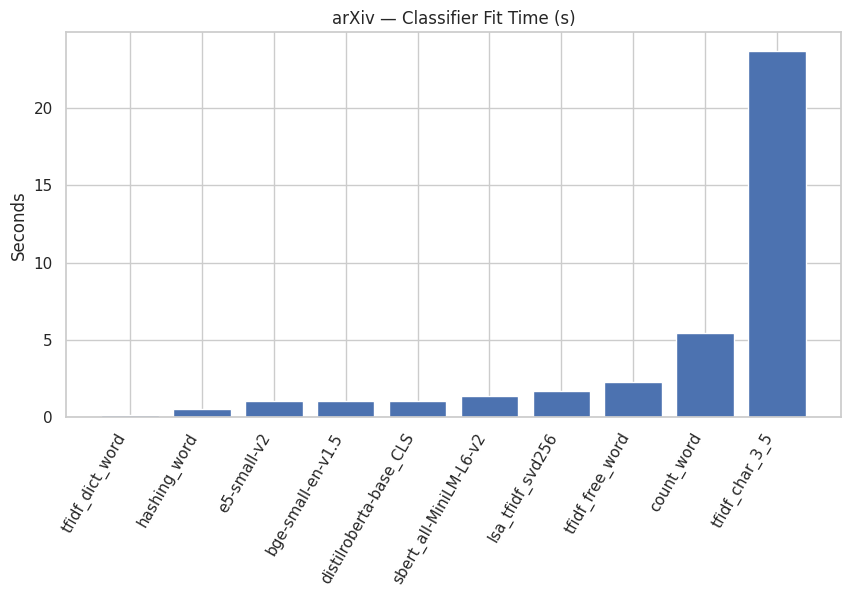

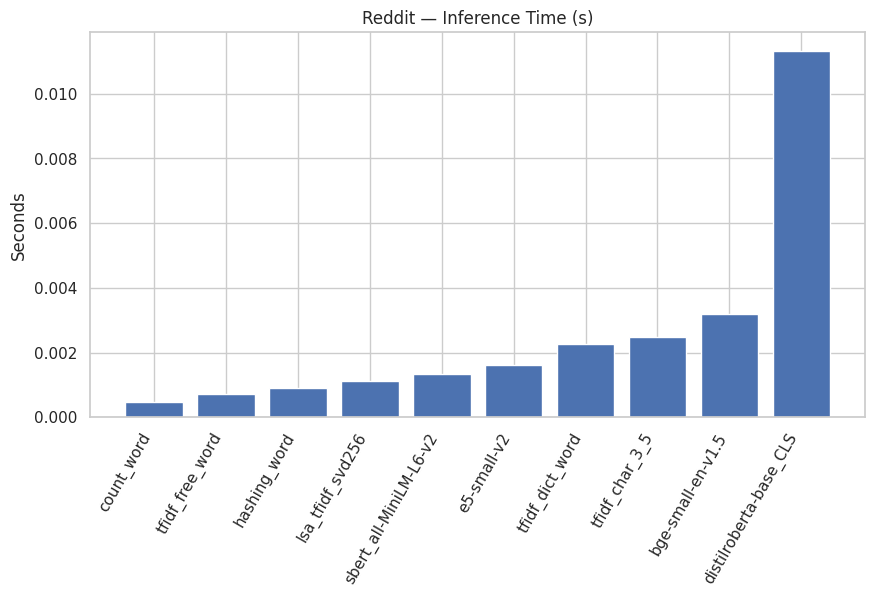

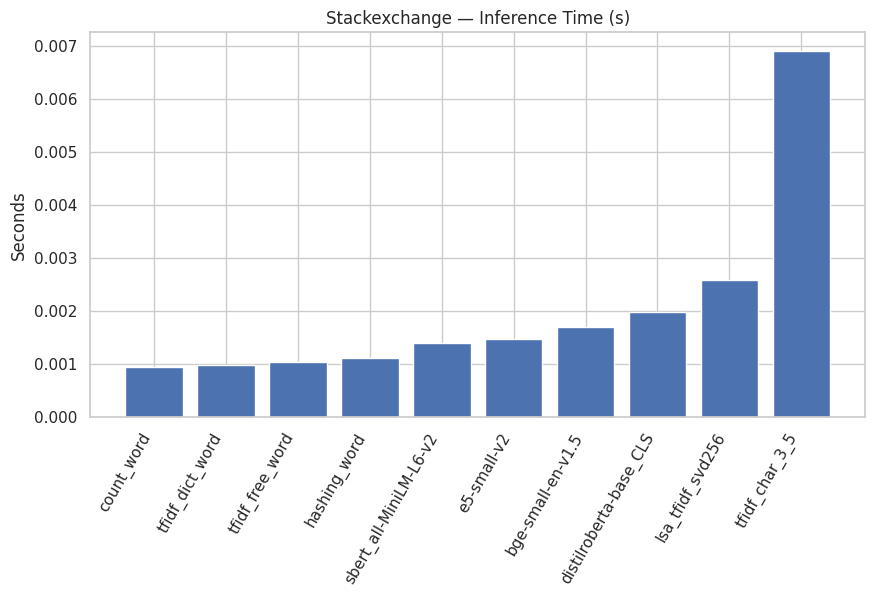

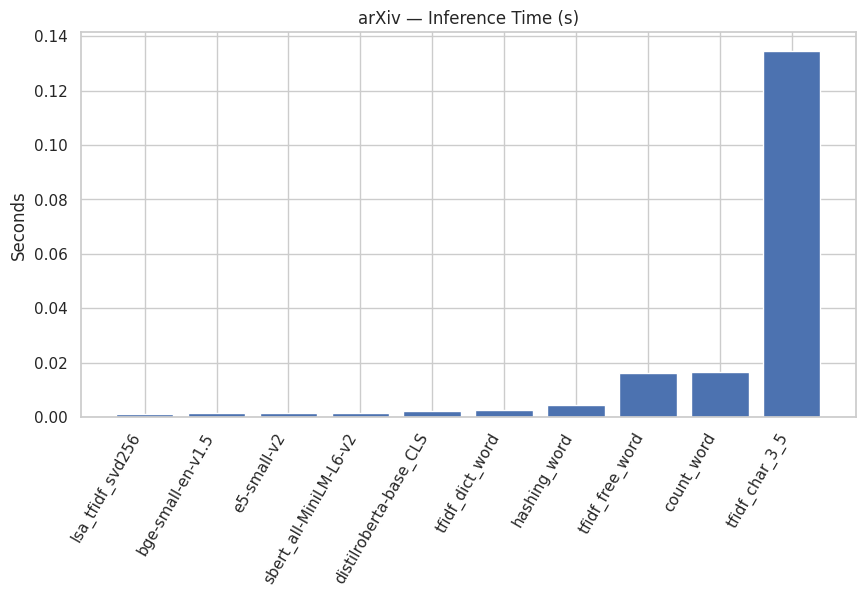

In [4]:
# Run with smaller slices first to sanity check (faster)
df = run_vectorizer_benchmark_10(limit_per_source=3000)

# When stable, run full 10k per source:
# df = run_vectorizer_benchmark_10(limit_per_source=10000)

In [1]:
df = run_vectorizer_benchmark_10(
    base_dir="/content/drive/MyDrive/CTC_by_source",
    reddit="CTC_Reddit_10k.json",
    stack="CTC_Stackexchange_10k.json",
    arxiv="CTC_arXiv_10k.json",
    limit_per_source=5000,  # adjust for speed
)

NameError: name 'run_vectorizer_benchmark_10' is not defined